# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
from lightning.pytorch import seed_everything

# seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
THRESHOLD = 2  # 外れ値除外の閾値

SAMPLE_SIZE = 1000  # 標本サイズ
DATA_SIZE = 100000  # データサイズ(df2)
N_TRIALS = 1000  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 2  # 分散を求める回数
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード

ALLOCATION_METHODS = [
    "Proportional",
    #   "Post",
    #  "Optimal",
]  # Randomはいれない
CLUSTERING_METHOD = "kmeans"  # "gmm" or "kmeans" or "xmeans"

if CLUSTERING_METHOD == "kmeans":
    CLUSTERING_METHOD_NAME = "K-means"
if CLUSTERING_METHOD == "xmeans":
    CLUSTERING_METHOD_NAME == "X-means"
if CLUSTERING_METHOD == "gmm":
    CLUSTERING_METHOD_NAME == "GMM"

# クラスタを固定する場合(gmm, kmeans)
N_CLUSTERS = 10  # クラスタ数
# クラスタ数を固定しない場合（xmeans)
K_MIN = 2
K_MAX = 8


MAXIMUM_FEATURES_TO_SELECT = 2  # 選択される最大の特徴量数

SELECTING_FEATURES = "all_features"  # 特徴量をmaxになるまで選ぶ⇒"all_features" or 基準値が最大になるまで⇒"not_all_features"

-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)
obj1 = "GMV"
features_list1 = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]
obj2 = obj1
features_list2 = features_list1

##### 外れ値除去と標準化

In [5]:
df = df2  # choose from (df1, df2)
obj = obj2  # choose from (obj1, obj2)
features_list = features_list2  # choose from (features_list1, features_list2)

# 外れ値除去
df = remove_outliers_zscore(data=df, metric=obj, threshold=THRESHOLD)

# 標準化
X = df[features_list]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaled_features, columns=features_list)

# 目的変数
y = df[obj]

# 行を詰める
df = df.reset_index(drop=True)

print("外れ値除外前のデータ数:", DATA_SIZE)
print("外れ値除外後のデータ数:", len(df))

外れ値除外前のデータ数: 100000
外れ値除外後のデータ数: 99082


### 単純無作為抽出（Random）の誤差分散のリスト

In [6]:
RANDOM_STD_LIST = []
for exp in range(N_EXPERIMENT):
    y_hats = []
    for random_state in range(N_TRIALS):
        sample = np.random.choice(y, SAMPLE_SIZE, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    errors = np.array(y_hats) - y.mean()
    random_std = errors.var()
    RANDOM_STD_LIST.append(random_std)
print(RANDOM_STD_LIST)

[22693.500184879773, 22947.56190284411]


-------------
### 提案手法でクラスタリング

##### Allocation_in_Wrapper Class

In [7]:
class Allocation_in_Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        clustering_method: str = "kmeans",
        allocation_methods: list[str] = ["Proportional"],
        sample_size: int = 10,
        n_trials: int = 100,
        m_value=2,
        M: Optional[NDArray] = None,
        random_state: int = 0,
        selecting_features: str = "all_features",
        k_min: int = 2,
        k_max: int = 10,
        random_allocation_std: float = 0.1,
    ):
        self.maximum_features_to_select = maximum_features_to_select
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.allocation_methods = allocation_methods
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.m_value = m_value
        self.M = M
        self.random_state = random_state
        self.selecting_features = selecting_features
        self.k_min = k_min
        self.k_max = k_max
        self.random_allocation_std = random_allocation_std

    def fss(self, X: pd.DataFrame, y: pd.DataFrame) -> "Allocation_in_Wrapper":
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数
        self.final_selected_features_dict = {}  # キー：標本配分手法, 値：最終的に選ばれた特徴量のリスト
        self.final_cluster_assignments_dict = {}  # キー：標本配分手法, 値：最終的なクラスタラベル
        self.features_score_dict_dict = {}  # キー：標本配分手法, 値：features_score_dict
        self.features_error_variance_dict_dict = {}  # キー：標本配分手法, 値：features_error_variance_dict
        self.final_n_clusters_dict = {}  # キー：標本配分手法, 値：最終的なクラスタ数
        self.final_score_dict = {}
        self.final_error_variance_dict = {}

        # 特徴量選択
        for allocation_method in self.allocation_methods:
            print("[", allocation_method, "]")

            features_score_dict = {}
            features_error_variance_dict = {}

            # 選ばれた特徴量と残っている特徴量の初期化
            current_features = []
            remaining_features = list(range(n_all_features))
            best_labels = [-1 for i in range(len(X))]
            best_n_clusters = -1
            if self.selecting_features == "not_all_features":
                best_score = -np.inf

            while len(current_features) < self.maximum_features_to_select:
                if self.selecting_features == "all_features":
                    best_score = -np.inf
                best_feature = None  # 選ぶ特徴量の初期化

                for feature in remaining_features:
                    temp_features = tuple(
                        current_features + [feature]
                    )  # 特徴量をひとつ加え、score計算
                    score, error_variance, n_clusters = self.crit(
                        X[:, temp_features], y, allocation_method
                    )
                    if score > best_score:
                        best_score = score
                        best_error_variance = error_variance
                        best_feature = feature
                        best_labels = self.N_cluster_label
                        best_N_cluster_size = self.N_cluster_size
                        best_n_clusters = n_clusters
                        best_n_cluster_size = self.n_cluster_size

                if best_feature is not None:
                    current_features.append(best_feature)
                    num_of_features = len(current_features)
                    print(
                        "num_of_features:",
                        num_of_features,
                        "current_features:",
                        current_features,
                        ", score:",
                        best_score,
                        "best_n_clusters:",
                        best_n_clusters,
                        "best_N_cluster_size:",
                        best_N_cluster_size,
                        "best_n_cluster_size:",
                        best_n_cluster_size,
                    )

                    features_score_dict[str(num_of_features)] = best_score  # 確認用
                    features_error_variance_dict[str(num_of_features)] = (
                        best_error_variance
                    )

                    remaining_features.remove(best_feature)
                    self.selected_features_ = current_features
                else:
                    break

            self.final_cluster_assignments_dict[allocation_method] = best_labels
            self.final_n_clusters_dict[allocation_method] = best_n_clusters
            self.final_selected_features_dict[allocation_method] = (
                self.selected_features_
            )
            self.features_score_dict_dict[allocation_method] = features_score_dict
            self.features_error_variance_dict_dict[allocation_method] = (
                features_error_variance_dict
            )
            self.final_score_dict[allocation_method] = best_score
            self.final_error_variance_dict[allocation_method] = best_error_variance

        return self

    def crit(self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        self.N_cluster_label = model.predict(X)
        self.N_cluster_size = np.bincount(self.N_cluster_label)
        n_clusters = len(np.unique(self.N_cluster_label))

        error_variance_reduction_rate, error_variance = self.cauculate_reduction_rate(
            X, y, allocation_method
        )
        score = error_variance_reduction_rate

        return score, error_variance, n_clusters

    def compute_bic(self, X: pd.DataFrame, kmeans):
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X: pd.DataFrame):
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def cauculate_reduction_rate(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:
        # 各戦略の標本数に基づいて目的変数の平均を推定
        y_hats = []
        for random_state in range(self.n_trials):
            if allocation_method == "Post":
                y_hat = self.estimate_y_mean_post(X, y)
            else:
                y_hat = self.estimate_y_mean_other(X, y, allocation_method)
            y_hats.append(
                {
                    "policy": allocation_method,
                    "y_hat": y_hat,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)
        y_hat_df["error"] = (
            y_hat_df["y_hat"] - y.mean()
        )  # 真の平均からの誤差をerrorカラムに追加

        non_random_allocation_std = y_hat_df["error"].var()
        print("non_random_alloccation_std", non_random_allocation_std)

        # 削減率
        reduction_rate = (
            1 - non_random_allocation_std / self.random_allocation_std
        ) * 100

        return reduction_rate, non_random_allocation_std

    def estimate_y_mean_post(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        n_cluster_size = np.array([self.sample_size])
        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        indices = np.arange(self.N_cluster_size.sum())
        y_array = np.array(y.tolist())
        n_indices = np.random.choice(indices, n_cluster_size[0], replace=False)
        n_label = np.array([self.N_cluster_label[i] for i in n_indices])
        n_new_labels = np.unique(n_label)
        self.n_cluster_size = np.bincount(n_label)
        for h in n_new_labels:
            index = np.where(n_label == h)[0]
            sample = y_array[n_indices[index]]
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
        return y_hat

    def estimate_y_mean_other(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:
        if allocation_method == "Proportional":
            self.n_cluster_size = self.ProportionalAllocation(X, y)
        if allocation_method == "Optimal":
            self.n_cluster_size = self.OptimalAllocation(X, y)

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        for h in range(self.n_cluster_size.shape[0]):
            if self.n_cluster_size[h] != 0:
                y_cluster = y[self.N_cluster_label == h]
                if self.n_cluster_size[h] <= len(y_cluster):
                    sample: NDArray = np.random.choice(
                        y_cluster, self.n_cluster_size[h], replace=False
                    )
                    y_sample_mean = sample.mean()  # サンプリングした標本の平均
                    y_hat += y_sample_mean * weights[h]
        return y_hat

    def ProportionalAllocation(self, X: pd.DataFrame, y: pd.DataFrame) -> NDArray:
        n_cluster_size: NDArray = np.round(
            self.N_cluster_size / self.N_cluster_size.sum() * self.sample_size
        ).astype(int)

        if n_cluster_size.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n_cluster_size[np.argmax(n_cluster_size)] -= (
                n_cluster_size.sum() - self.sample_size
            )
        if n_cluster_size.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n_cluster_size[np.argmax(n_cluster_size)] += (
                -n_cluster_size.sum() + self.sample_size
            )
        return n_cluster_size

    def OptimalAllocation(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> NDArray:  # たぶんあってる
        n_cluster = len(np.unique(self.N_cluster_label))
        self.m = np.full(n_cluster, self.m_value)
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.N_cluster_label == h]) for h in range(n_cluster)])
        d = (self.N_cluster_size**2) * S

        n_cluster_size = self.m.copy()  # 初期値

        M = self.M.copy() if self.M is not None else self.N_cluster_size.copy()
        I = np.arange(n_cluster)  # noqa #クラスタのインデックス   ###############self.n_clusters
        while (n_cluster_size.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(n_cluster)  ############self.n_clusters
            delta[I] = (d / (n_cluster_size + 1) - d / n_cluster_size)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n_cluster_size[h_star] + 1 <= M[h_star]:
                n_cluster_size[h_star] = n_cluster_size[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        # 制約チェック
        assert (
            n_cluster_size.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n_cluster_size >= self.m
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n_cluster_size <= self.M
            ), "Maximum sample size constraint is not satisfied"

        return n_cluster_size

    def get_final_selected_features_dict(self) -> dict[NDArray]:
        return self.final_selected_features_dict  # 選択された特徴量のインデックス

    def get_final_cluster_assignments(self) -> dict[NDArray]:
        return self.final_cluster_assignments_dict  # 最終的なクラスタリング結果

    def get_final_n_clusters_dict(self) -> dict:
        return self.final_n_clusters_dict

    def get_final_score_dict(self) -> dict:
        return self.final_score_dict

    def get_final_error_variance_dict(self) -> dict:
        return self.final_error_variance_dict

    def get_features_score_dict_dict(self) -> dict[dict]:
        return self.features_score_dict_dict

    def get_features_error_variance_dict_dict(self) -> dict[dict]:
        return self.features_error_variance_dict_dict

----------------
### 実験結果

##### 実験回数が１回のとき

In [8]:
np.random.seed(0)
ins = Allocation_in_Wrapper(
    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
    n_clusters=N_CLUSTERS,
    clustering_method=CLUSTERING_METHOD,
    allocation_methods=ALLOCATION_METHODS,
    sample_size=SAMPLE_SIZE,
    n_trials=N_TRIALS,
    m_value=m_VALUE,
    random_state=RANDOM_STATE,
    selecting_features=SELECTING_FEATURES,
    k_min=K_MIN,
    k_max=K_MAX,
    random_allocation_std=RANDOM_STD_LIST[0],
)

ins.fss(X_scaled, y)
selected_features_index = ins.get_final_selected_features_dict()
cluster_label = ins.get_final_cluster_assignments()
cluster_size = np.unique(cluster_label, return_counts=True)[1]
features_score_dict_dict = ins.get_features_score_dict_dict()
features_error_variance_dict_dict = ins.get_features_error_variance_dict_dict()

[ Proportional ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


non_random_alloccation_std 20968.06823079546
non_random_alloccation_std 21064.048332085185


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


non_random_alloccation_std 22301.27017894523
non_random_alloccation_std 19598.084643041122
non_random_alloccation_std 19735.700703477534
non_random_alloccation_std 19191.835671249024
non_random_alloccation_std 23213.557019149914
non_random_alloccation_std 24559.49768711456
non_random_alloccation_std 24431.117670325246
non_random_alloccation_std 23680.39168003296
non_random_alloccation_std 23701.82838028705
non_random_alloccation_std 22344.551211379305
non_random_alloccation_std 24476.065055427047
non_random_alloccation_std 22344.180829560522
non_random_alloccation_std 20155.05994567001
non_random_alloccation_std 23613.679404148632
non_random_alloccation_std 23804.31230198711
num_of_features: 1 current_features: [5] , score: 15.430253090547218 best_n_clusters: 10 best_N_cluster_size: [61383   472  3373     3    10   143 23322  1294    55  9027] best_n_cluster_size: [620   5  34   0   0   1 235  13   1  91]
non_random_alloccation_std 19426.507164847313
non_random_alloccation_std 19944.72

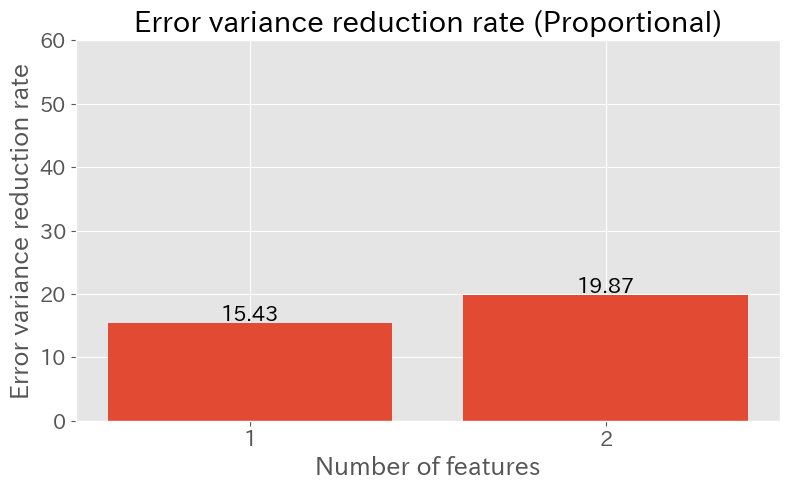

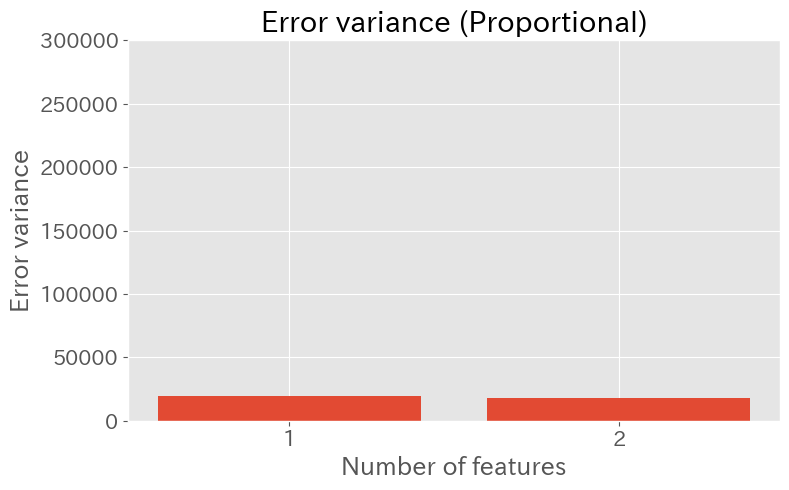

In [9]:
# グラフ作成
fig, axs = plt.subplots(
    1, len(ALLOCATION_METHODS), figsize=(8 * len(ALLOCATION_METHODS), 5)
)  # サブプロットを作成


plot_idx = 0
for allocation, dict in features_score_dict_dict.items():
    if len(features_score_dict_dict) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    bars = ax.bar(dict.keys(), dict.values())
    for key, value in dict.items():
        rounded_value = round(value, 2)
        ax.text(key, value + 0.3, str(rounded_value), ha="center", fontsize=15)
    ax.set_title(f"Error variance reduction rate ({allocation})", fontsize=21)
    ax.set_xlabel("Number of features", fontsize=18)
    ax.set_ylabel("Error variance reduction rate", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_ylim([0, 60])  # Y軸の範囲を0から20に設定
    plot_idx += 1

plt.tight_layout()
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    1, len(ALLOCATION_METHODS), figsize=(8 * len(ALLOCATION_METHODS), 5)
)  # サブプロットを作成

plot_idx = 0
for allocation, dict in features_error_variance_dict_dict.items():
    if len(features_score_dict_dict) == 1:
        ax = axs
    else:
        ax = axs[plot_idx]
    bars = ax.bar(dict.keys(), dict.values())
    for key, value in dict.items():
        rounded_value = round(value, 2)
        # ax.text(key, value + 10, str(rounded_value), ha="center", fontsize=15)
    # random_bar = ax.bar("ran", RANDOM_ALLOCATION_STD, color="blue")
    # ax.text("random", random_std + 0.3, str(round(random_std, 2)), ha="center")
    ax.set_title(f"Error variance ({allocation})", fontsize=21)
    ax.set_xlabel("Number of features", fontsize=18)
    ax.set_ylabel("Error variance", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=15)
    ax.set_ylim([0, 300000])  # Y軸の範囲を0から20に設定
    plot_idx += 1

plt.tight_layout()
plt.show()

##### 実験回数がN_EXPERIMENT のとき

In [10]:
all_reduction_rate_dict = {}
all_reduction_rate_dict["Random"] = [0 for i in range(N_EXPERIMENT)]
for allocation_method in ALLOCATION_METHODS:
    all_reduction_rate_dict[allocation_method] = []

all_error_variance_dict = {}
all_error_variance_dict["Random"] = RANDOM_STD_LIST
for allocation_method in ALLOCATION_METHODS:
    all_error_variance_dict[allocation_method] = []

for exp in range(N_EXPERIMENT):
    np.random.seed(exp)
    ins = Allocation_in_Wrapper(
        maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
        n_clusters=N_CLUSTERS,
        clustering_method=CLUSTERING_METHOD,
        allocation_methods=ALLOCATION_METHODS,
        sample_size=SAMPLE_SIZE,
        n_trials=N_TRIALS,
        m_value=m_VALUE,
        random_state=RANDOM_STATE,
        selecting_features=SELECTING_FEATURES,
        k_min=K_MIN,
        k_max=K_MAX,
        random_allocation_std=RANDOM_STD_LIST[exp],
    )

    ins.fss(X_scaled, y)
    final_score_dict = ins.get_final_score_dict()
    final_error_variance_dict = ins.get_final_error_variance_dict()
    for allocation_method in ALLOCATION_METHODS:
        all_reduction_rate_dict[allocation_method].append(
            final_score_dict[allocation_method]
        )
        all_error_variance_dict[allocation_method].append(
            final_error_variance_dict[allocation_method]
        )

mean_reduction_rate_dict = {}
mean_reduction_rate_dict["Random"] = 0
for allocation_method in ALLOCATION_METHODS:
    mean_reduction_rate_dict[allocation_method] = sum(
        all_reduction_rate_dict[allocation_method]
    ) / len(all_reduction_rate_dict[allocation_method])

mean_error_variance_dict = {}
mean_error_variance_dict["Random"] = sum(RANDOM_STD_LIST) / N_EXPERIMENT
for allocation_method in ALLOCATION_METHODS:
    mean_error_variance_dict[allocation_method] = sum(
        all_error_variance_dict[allocation_method]
    ) / len(all_error_variance_dict[allocation_method])

[ Proportional ]
non_random_alloccation_std 20968.06823079546
non_random_alloccation_std 21064.048332085185


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


non_random_alloccation_std 22301.27017894523
non_random_alloccation_std 19598.084643041122
non_random_alloccation_std 19735.700703477534
non_random_alloccation_std 19191.835671249024
non_random_alloccation_std 23213.557019149914
non_random_alloccation_std 24559.49768711456
non_random_alloccation_std 24431.117670325246
non_random_alloccation_std 23680.39168003296
non_random_alloccation_std 23701.82838028705
non_random_alloccation_std 22344.551211379305
non_random_alloccation_std 24476.065055427047
non_random_alloccation_std 22344.180829560522
non_random_alloccation_std 20155.05994567001
non_random_alloccation_std 23613.679404148632
non_random_alloccation_std 23804.31230198711
num_of_features: 1 current_features: [5] , score: 15.430253090547218 best_n_clusters: 10 best_N_cluster_size: [61383   472  3373     3    10   143 23322  1294    55  9027] best_n_cluster_size: [620   5  34   0   0   1 235  13   1  91]
non_random_alloccation_std 19426.507164847313
non_random_alloccation_std 19944.72

c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


non_random_alloccation_std 23394.21563798785
non_random_alloccation_std 19426.021146581348
non_random_alloccation_std 19330.307522536386
non_random_alloccation_std 17662.622927784083
non_random_alloccation_std 21536.380017073476
non_random_alloccation_std 21966.46499991106
non_random_alloccation_std 21981.999703123565
non_random_alloccation_std 22163.293254167846
non_random_alloccation_std 21833.866564588952
non_random_alloccation_std 22123.448349074897
non_random_alloccation_std 23753.793629526877
non_random_alloccation_std 22297.37896160753
non_random_alloccation_std 21156.404569606053
non_random_alloccation_std 21710.521624780333
non_random_alloccation_std 22465.32507724958
num_of_features: 1 current_features: [5] , score: 23.03050318563479 best_n_clusters: 10 best_N_cluster_size: [61383   472  3373     3    10   143 23322  1294    55  9027] best_n_cluster_size: [620   5  34   0   0   1 235  13   1  91]
non_random_alloccation_std 19284.952547075005
non_random_alloccation_std 18075.1

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_10928\3296206419.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)


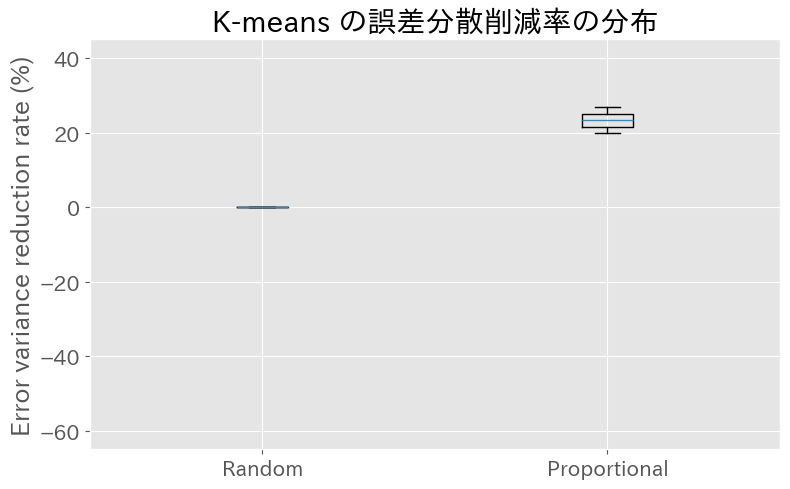

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_10928\3296206419.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(allo_data, labels=allo_labels)


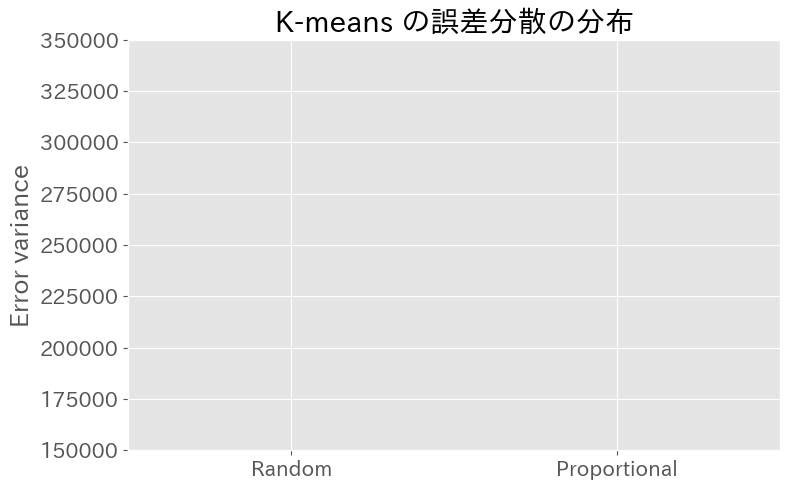

In [11]:
# 誤差分散削減率の箱ひげ図
fig, axs = plt.subplots(1, 1, figsize=(8, 5))  # サブプロットを作成

ax = axs
allo_data = list(all_reduction_rate_dict.values())  # allo1, allo2, allo3 のデータリスト
allo_labels = list(all_reduction_rate_dict.keys())  # alloのラベルリスト
ax.boxplot(allo_data, labels=allo_labels)
# グラフタイトルを設定
ax.set_title(f"{CLUSTERING_METHOD_NAME} の誤差分散削減率の分布", fontsize=21)
ax.set_ylabel("Error variance reduction rate (%)", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_ylim(-65, 45)

# グラフを表示
plt.tight_layout()  # レイアウトを調整
plt.show()


# 誤差分散の箱ひげ図
fig, axs = plt.subplots(1, 1, figsize=(8, 5))  # サブプロットを作成

ax = axs
allo_data = list(all_error_variance_dict.values())  # allo1, allo2, allo3 のデータリスト
allo_labels = list(all_error_variance_dict.keys())  # alloのラベルリスト
ax.boxplot(allo_data, labels=allo_labels)
# グラフタイトルを設定
ax.set_title(f"{CLUSTERING_METHOD_NAME} の誤差分散の分布", fontsize=21)
ax.set_ylabel("Error variance", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_ylim(150000, 350000)

# グラフを表示
plt.tight_layout()  # レイアウトを調整
plt.show()

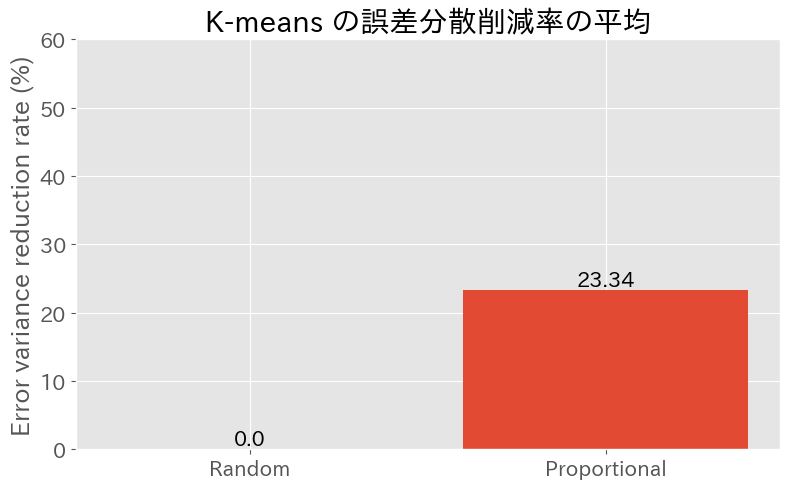

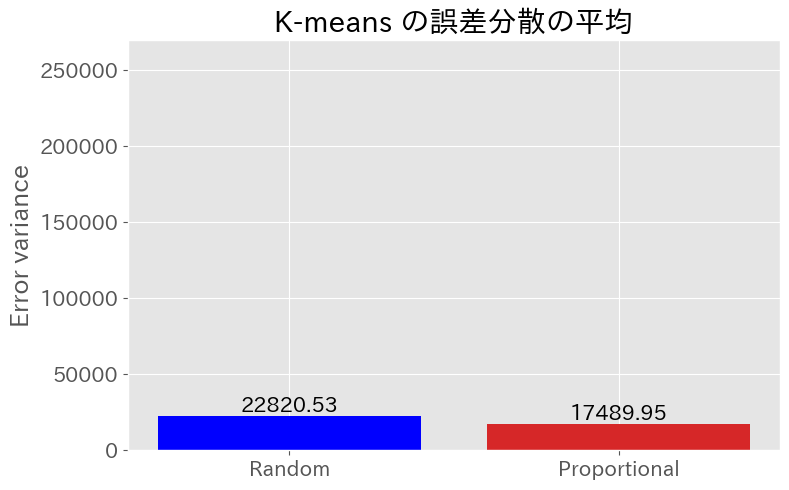

In [12]:
# グラフ作成
fig, axs = plt.subplots(
    1,
    1,
    figsize=(8, 5),
)  # サブプロットを作成

ax = axs
allo_data = list(
    mean_reduction_rate_dict.values()
)  # allo1, allo2, allo3 のデータリスト
allo_labels = list(mean_reduction_rate_dict.keys())  # alloのラベルリスト
bars = ax.bar(allo_labels, allo_data)
# 各バーの上に値を表示
for bar in bars:
    yval = bar.get_height()  # 各バーの高さ（値）
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
        fontsize=15,
    )  # 値をバーの上に表示
    # plt.ylabel("誤差分散削減率 (%)")
ax.set_ylabel("Error variance reduction rate (%)", fontsize=18)
ax.set_ylim(0, 60)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_title(
    f"{CLUSTERING_METHOD_NAME} の誤差分散削減率の平均", fontsize=21
)  # (number of clusters: {clusters})")

plt.tight_layout()
plt.show()


# グラフ作成
fig, axs = plt.subplots(
    1,
    1,
    figsize=(8, 5),
)  # サブプロットを作成

ax = axs
allo_data = list(
    mean_error_variance_dict.values()
)  # allo1, allo2, allo3 のデータリスト
allo_labels = list(mean_error_variance_dict.keys())  # alloのラベルリスト

# bars = ax.bar(allo_labels, allo_data, color="tab:red")
bars = ax.bar(
    allo_labels,
    allo_data,
    color=["blue" if label == "Random" else "tab:red" for label in allo_labels],
)
for bar in bars:
    yval = bar.get_height()  # 各バーの高さ（値）
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        ha="center",
        va="bottom",
        fontsize=15,
    )  # 値をバーの上に表示
ax.set_ylabel("Error variance", fontsize=18)
ax.set_ylim(0, 270000)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.set_title(f"{CLUSTERING_METHOD_NAME} の誤差分散の平均", fontsize=21)

plt.tight_layout()
plt.show()